# Music information retrieval

In [1]:
# Números y Datos
import numpy as np
import pandas as pd

# Para visuzalización
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import boxplot

# Parseo de Json
import ast

# Escalado de datos
from sklearn.preprocessing import MinMaxScaler

# Clusters y metricas
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

import scipy.cluster.hierarchy as shc

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## 1. Carga de datos

Cargo los datos pre-procesados en el Pre TP


### Audio Features (audio_features_normalizadas)

In [2]:
#Carga de datos de audio features
git_hub_path = "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/"

audio_features_normalizadas = pd.read_csv(git_hub_path + "audio_features_normalizadas.csv" , index_col='id')
metadata = pd.read_csv(git_hub_path + "metadata.csv" , index_col='id')
metadata_genre = metadata[['Genero']]

#Elegimos solo las variables continuas
audio_features_normalizadas = audio_features_normalizadas[['acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'key', 'liveness', 'loudness','speechiness', 'tempo','valence', 'Genero']]
audio_features_normalizadas.head()

acousticness  danceability  duration_ms    energy  \
id                                                                          
5i2sgqnzaxYpvXmGAB592h      0.960843      0.548122     0.082639  0.107589   
4mGzm5ahHxMX5IhVWbU7cl      0.956827      0.496479     0.080985  0.031669   
4DEn3hZzSs9MFwFNDla5Y5      0.992972      0.395540     0.055235  0.149656   
5P6vo51dtkBYWXswH1twvK      0.174695      0.474178     0.240354  0.773642   
29TZQMVLv25CBm3bYn2EIQ      0.437748      0.463615     0.111798  0.501211   

                        instrumentalness       key  liveness  loudness  \
id                                                                       
5i2sgqnzaxYpvXmGAB592h          0.001237  0.000000  0.124419  0.585975   
4mGzm5ahHxMX5IhVWbU7cl          0.000004  0.363636  0.082086  0.465891   
4DEn3hZzSs9MFwFNDla5Y5          0.913481  0.454545  0.334022  0.524560   
5P6vo51dtkBYWXswH1twvK          0.706237  0.818182  0.695405  0.764218   
29TZQMVLv25CBm3bYn2EIQ          0.905433  0.909091  0.094476  0.701451   

                        speechiness     tempo   valence Genero  
id                                                              
5i2sgqnzaxYpvXmGAB592h     0.046954  0.481591  0.314541   jazz  
4mGzm5ahHxMX5IhVWbU7cl     0.067078  0.444450  0.158519   jazz  
4DEn3hZzSs9MFwFNDla5Y5     0.021574  0.300881  0.156439   jazz  
5P6vo51dtkBYWXswH1twvK     0.224075  0.494300  0.487206   jazz  
29TZQMVLv25CBm3bYn2EIQ     0.017223  0.381335  0.605783   jazz

### Timbre y Pitch (audio_analysis_norm_genre):
Para el análisis de pitches y timbre, generaremos mediante una función variables relacionadas con la evolución de las mediciones. Se analizará para los rangos de percentil 10 la media, desvio, mínimo, máximo y la distribución interna del decil mediante los percentiles 25, 50 y 75. 

In [3]:
def percentil_function(n):
    def percentile_aux_func(x):
        return np.percentile(x, n)
    percentile_aux_func.__name__ = 'percentil_%s' % n
    return percentile_aux_func

#Pitches
files_pitches = ["https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/pitches_full-1.csv",
                 "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/pitches_full-2.csv",
                 "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/pitches_full-3.csv",
                 "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/pitches_full-4.csv"]

#Timbre
files_timbre = ["https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/timbres_full-1.csv",
                "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/timbres_full-2.csv",
                "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/timbres_full-3.csv",
                "https://raw.githubusercontent.com/JuanMarchese/TPsMaestriaDatamining/master/CienciaYTecnologia/audio_analysis/timbres_full-4.csv"]


In [4]:
#cargo los datos

pitches_list = []
for file in files_pitches:
    pitches_list.append(pd.read_csv(file,index_col="names"))

pitches = pd.concat(pitches_list)

timbres_list = []
for file in files_timbre:
    timbres_list.append(pd.read_csv(file,index_col="names"))

timbres = pd.concat(timbres_list)


column_generation = {}
for i in range(12):
    column_generation[str(i)] = ['mean','std','min','max',percentil_function(25),percentil_function(50),percentil_function(75)]

timbres_aggregated = timbres.groupby(['names'], as_index=True).agg(column_generation)
timbres_aggregated.columns = ['%s%s' % (a, '|%s' % b if b else '') for a, b in timbres_aggregated.columns]

pitches_aggregated = pitches.groupby(['names'], as_index=True).agg(column_generation)
pitches_aggregated.columns = ['%s%s' % (a, '|%s' % b if b else '') for a, b in pitches_aggregated.columns]

#Se escalan las variables.
scaler = MinMaxScaler() 

timbres_aggregated_normalized = timbres_aggregated
scaled_values = scaler.fit_transform(timbres_aggregated) 
timbres_aggregated_normalized.loc[:,:] = scaled_values

pitches_aggregated_normalized = pitches_aggregated
scaled_values = scaler.fit_transform(pitches_aggregated) 
pitches_aggregated_normalized.loc[:,:] = scaled_values

#Se crea finalmente el dataframe de audio analysis
audio_analysis_norm = pd.merge(pitches_aggregated_normalized, timbres_aggregated_normalized, how='inner', left_index=True, right_index=True)
audio_analysis_norm_genre = pd.merge(audio_analysis_norm, metadata_genre, how='inner', left_index=True, right_index=True)

#audio_analysis_norm_genre = audio_analysis_norm_genre.loc[[audio_features_normalizadas.index],:]
# feature tiene mas registros que analysis (2)
audio_features_normalizadas = audio_features_normalizadas.loc[audio_analysis_norm_genre.index,:] 

En este punto contamos con dos dataframes:
1. audio_analysis_norm_genre: que cuenta con el analisis del timbre y pitches. Se generan variables (media, desvio, minimo, maximo, percentil 25, percentil 50 y percentil 75) por cada una de las variables que componen el timbre y pitches. Por ultimo se mergea todo en una misma tabla.
2. audio_features_normalizadas: caracteristicas globales del tema. Se encuentran normalizadas.

## 2. Evaluacion de variables



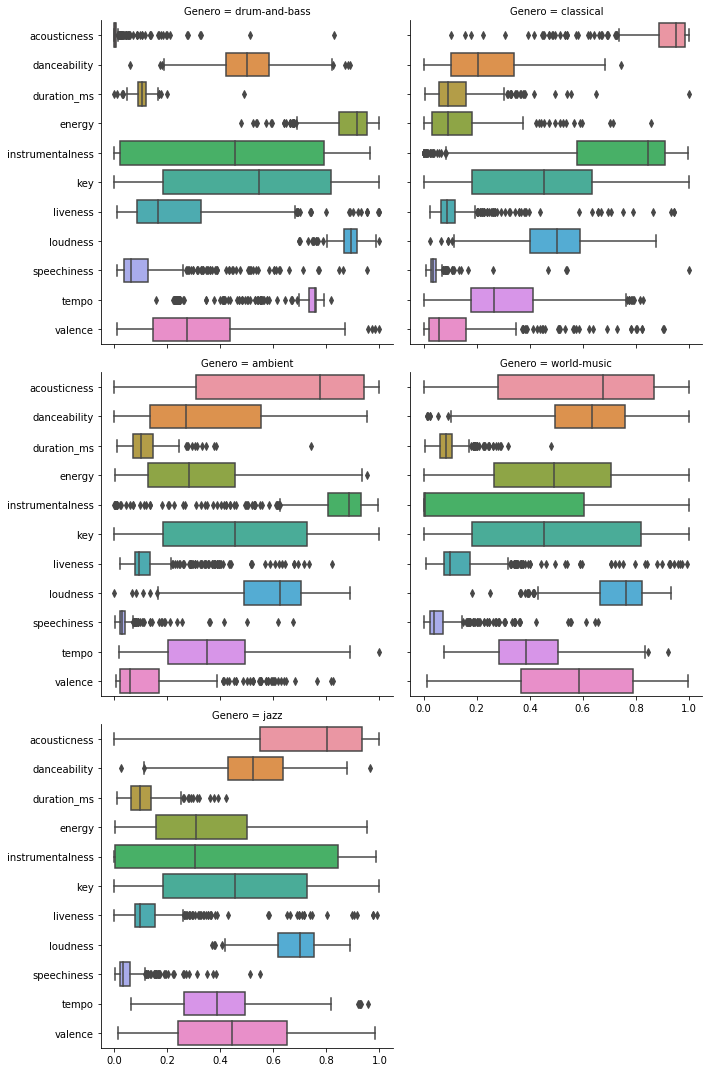

In [5]:
# seleccionamos las variables a evaluar
var_boxplot=['acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'key', 'liveness', 'loudness','speechiness', 'tempo','valence', 'Genero']
sns.catplot(data=audio_features_normalizadas[var_boxplot],kind='box', col= 'Genero',orient="h",col_wrap=2)

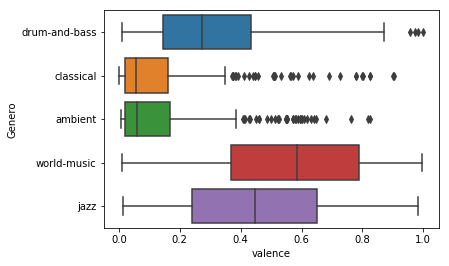

In [6]:
n=10
sns.boxplot(x=var_boxplot[n],y="Genero",data=audio_features_normalizadas)

A diferencia de lo observado en pitches, el timbre presenta un comportamiento muy diferente en cada medicion. Esto se observa tanto en la media como en el desvio.

Los datos atípicos de la media se observan tanto a derecha como a izquierda. Respecto al desvio, si bien se observan algunos casos (medicion 8 y 10) que presentan datos atipicos a ambos lados de la distribucion, la mayoria de los atributos presentan datos atípicos a derecha de la distribución.

Ambas caracteristicas reportan datos atípicos en las 12 mediciones. Se deberá evaluar dependiendo del modelo a utilizar si es conveniente o no realizar algún tipo de acción.


## __Clustering k-means__

La consigna consiste en aplicar distintos algoritmos de clustering y explorar sus hiperparámetros en base a métricas de validación.

a) Utilizando sólo datos continuos, aplicar KMeans sobre ambos conjuntos de datos por separado y combinados (audio_features y audio_analysis). Determinar la cantidad de clusters utilizando silhuette y SSE.

In [16]:
def silhouette_kmeans(df, kmeans):
    return silhouette_score(df, kmeans.labels_)

def sse_kmeans(df, kmeans):
    return kmeans.inertia_

def ajuste_clusters_kmeans(df, kmeans):
    sample_silhouette_values = silhouette_samples(df, kmeans.labels_)
    cluster_labels = kmeans.labels_
    n_clusters=len(np.unique(cluster_labels))
    ith_cluster_silhouette_avg = []
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        mean = '{0:.4f}'.format(np.mean(ith_cluster_silhouette_values))
        ith_cluster_silhouette_avg.append(mean) 
    return (ith_cluster_silhouette_avg)

def evaluar_cluster(df):
    for i in range(2,10,1):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(df)
        print('Silhouette:',
              round(silhouette_kmeans(df, kmeans),3),
              ', SSE:',
              round(sse_kmeans(df, kmeans),3),
              'para',
              i,
              'clusters.')
        print('Ajuste de cada cluster particular: ', ajuste_clusters_kmeans(df, kmeans))
        print("")


### Clustering sobre audio_analysis

Evaluamos el número de cluster óptimo.

In [17]:
df = audio_analysis_norm_genre.drop(['Genero'], axis=1)
evaluar_cluster(df)

Silhouette: 0.113 , SSE: 6304.876 para 2 clusters.
Ajuste de cada cluster particular:  ['0.1902', '0.0354']

Silhouette: 0.069 , SSE: 5971.497 para 3 clusters.
Ajuste de cada cluster particular:  ['0.1015', '-0.0198', '0.1086']

Silhouette: 0.074 , SSE: 5743.853 para 4 clusters.
Ajuste de cada cluster particular:  ['0.0270', '0.1076', '0.1013', '0.0016']

Silhouette: 0.077 , SSE: 5568.753 para 5 clusters.
Ajuste de cada cluster particular:  ['0.0024', '0.1054', '0.1106', '0.0504', '0.0277']

Silhouette: 0.051 , SSE: 5449.75 para 6 clusters.
Ajuste de cada cluster particular:  ['0.0867', '0.1082', '-0.0126', '0.0402', '0.0279', '0.0068']

Silhouette: 0.054 , SSE: 5349.513 para 7 clusters.
Ajuste de cada cluster particular:  ['0.0327', '0.0832', '0.1083', '0.0181', '-0.0107', '0.0506', '0.0170']

Silhouette: 0.045 , SSE: 5268.45 para 8 clusters.
Ajuste de cada cluster particular:  ['0.0300', '0.0130', '0.0858', '0.0501', '0.0510', '0.0758', '-0.0240', '0.0128']

Silhouette: 0.048 , SSE: 

Modelo óptimo

In [15]:
kmeans_audio_analysis = KMeans(n_clusters=2, random_state=0).fit(audio_analysis_norm_genre.drop(['Genero'],axis=1))

Conclusión:
Al iterar para encontrar el óptimo de clusters dentro de la base audio analysis, llegamos a la conclusión que éste debería ser 2. Sin perjuicio de lo expuesto el coeficiente de Silhouette, en promedio, es tan solo del 0.113. Siendo este coeficiente cercano a cero, implica que los datos no se encuentran definidos dentro de un cluster, sino que se encuentran entre dos clusters. Viendo desagregadamente los coeficientes intra clusters, podemos observar que habría un claster medianamente definido (coef. 0.19) y uno con un coeficiente de Silhouette muy bajo (0.035). Se puede concluir que, con los atributos generados y con el algorítmos propuesto no es posible definir claramente clusters. Mucho menos encontrar una correlación entre los clusters propuestos y los géneros musicales.

### Clustering sobre audio_feature

Evaluamos el número de cluster óptimo

In [18]:
df = audio_features_normalizadas.drop(['Genero'], axis=1)

evaluar_cluster(df)

Silhouette: 0.302 , SSE: 1119.309 para 2 clusters.
Ajuste de cada cluster particular:  ['0.3492', '0.2489']

Silhouette: 0.283 , SSE: 904.521 para 3 clusters.
Ajuste de cada cluster particular:  ['0.2427', '0.3489', '0.2338']

Silhouette: 0.264 , SSE: 800.194 para 4 clusters.
Ajuste de cada cluster particular:  ['0.2268', '0.3436', '0.1925', '0.2235']

Silhouette: 0.213 , SSE: 733.724 para 5 clusters.
Ajuste de cada cluster particular:  ['0.2392', '0.2161', '0.1770', '0.2069', '0.2136']

Silhouette: 0.206 , SSE: 676.886 para 6 clusters.
Ajuste de cada cluster particular:  ['0.2107', '0.2254', '0.2072', '0.1510', '0.2422', '0.1873']

Silhouette: 0.206 , SSE: 633.645 para 7 clusters.
Ajuste de cada cluster particular:  ['0.2700', '0.1926', '0.1050', '0.2099', '0.1954', '0.1995', '0.2101']

Silhouette: 0.2 , SSE: 598.575 para 8 clusters.
Ajuste de cada cluster particular:  ['0.2371', '0.0941', '0.1699', '0.2693', '0.1985', '0.2137', '0.1671', '0.1953']

Silhouette: 0.2 , SSE: 571.248 para

Modelo óptimo:


In [19]:
kmeans_audio_features = KMeans(n_clusters=5, random_state=0).fit(audio_features_normalizadas.drop(['Genero'],axis=1))

Conclusión: ésta clusterización reporta métricas mejores y más estables que los modelos realizados con audio_analysis. Particularmente se destaca el modelo con 6 clusters (un cluster más que los géneros) pero todos los modelos analizados tienen un coeficiente de Silhouette entre el 0.24 - 0.27. Analizando los coeficientes intra cluster para el caso de 6 clusters, podemos que ver la mayoria de los cluster resultar relevantes, destacandose el número 3 y 4 que superan el 0.3.

### Clustering sobre toda la base

Evaluación del número de clusters óptimo

In [20]:
df = pd.merge(audio_analysis_norm, audio_features_normalizadas, how='inner', left_index=True, right_index=True).drop(['Genero'],axis=1)

evaluar_cluster(df)

Silhouette: 0.143 , SSE: 7464.085 para 2 clusters.
Ajuste de cada cluster particular:  ['0.2000', '0.0887']

Silhouette: 0.091 , SSE: 6998.251 para 3 clusters.
Ajuste de cada cluster particular:  ['0.0293', '0.1159', '0.1292']

Silhouette: 0.09 , SSE: 6769.439 para 4 clusters.
Ajuste de cada cluster particular:  ['0.1177', '0.1215', '0.0520', '0.0228']

Silhouette: 0.062 , SSE: 6593.984 para 5 clusters.
Ajuste de cada cluster particular:  ['0.0977', '0.0520', '0.0997', '0.0048', '0.0297']

Silhouette: 0.064 , SSE: 6429.049 para 6 clusters.
Ajuste de cada cluster particular:  ['0.0115', '0.0981', '0.1074', '0.0496', '0.0486', '0.0257']

Silhouette: 0.061 , SSE: 6301.428 para 7 clusters.
Ajuste de cada cluster particular:  ['0.0028', '0.0319', '0.0755', '0.0103', '0.0996', '0.0517', '0.1050']

Silhouette: 0.053 , SSE: 6199.828 para 8 clusters.
Ajuste de cada cluster particular:  ['0.0370', '0.0744', '0.0904', '0.1032', '0.0015', '-0.0121', '0.0682', '-0.0139']

Silhouette: 0.054 , SSE: 6

Conclusión: previo al análisis puntual, suponíamos que la combinación de las dos bases debería haber permitido determinar mejor los cluster. En contraposición de éste supuesto, el modelo que mejor performó a penas superó el mejor modelo propuesto por audio_analysis. Llegamos a la conclusión que el número de clusters óptimo para toda la base debería ser 2. Sin perjuicio de lo expuesto el coeficiente de Silhouette, en promedio, es tan solo del 0.135 cabiendo todas las consideraciones observadas anteriormente. Consideramos que esto puede deberse a que el modelo considera a todas las variables y siendo de "peor calidad" y encontrandose en mayor número las variables de audio_analysis (son 168) afectan mucho a la performance de las variables de audio_feature.

Por último y a fin de definir cuál será nuestro modelo final se evaluó reforzar el modelo de audio_feature con atributos relevantes para la clusterización de la base audio_analysis. Para ello, se generaron combinaciones de 1, 2 y 3 atributos con las 168 variables de la base audio_analysis. Se evaluón el coeficiente de Silhouette combinando cada set de variables con las variables de audio_feature. Fueron aproximadamente 1.500k modelos.

In [ ]:
# con 5 clusters 0.258
analysis = audio_analysis_norm
feature = audio_features_normalizadas.drop(['Genero'],axis=1)
variables = analysis.columns
coeficiente = []

combinacion = [[variables[i]] for i in range(len(variables)-1)]
combinacion2 =[[variables[i],variables[z]] for i in range(len(variables)-1) for z in range(i+1,len(variables[i+1:len(variables)])-1)]

combinacion += combinacion2


for i in range(len(combinacion)):
    df = pd.merge(feature,analysis[combinacion[i]], how='inner', left_index=True, right_index=True)
    kmeans = KMeans(n_clusters=5, random_state=0).fit(df)
    promedio = silhouette_score(df, kmeans.labels_)
    coeficiente.append(round(promedio,4))

In [ ]:
d = {'combinacion': combinacion, 'coef. silhouette': coeficiente}
resultados = pd.DataFrame(data=d)
resultados.sort_values('coef. silhouette',ascending= False)

In [ ]:
resultados.to_csv(r'prueba.csv')

In [ ]:
resultados = pd.read_csv(r'prueba.csv')
resultados.sort_values('coef. silhouette',ascending= False)

Unnamed: 0                                combinacion  coef. silhouette
4305        4305            ['4|min_x', '0|percentil_50_y']            0.2257
968          968  ['0|percentil_25_x', '10|percentil_25_y']            0.2244
753          753                     ['0|max_x', '2|max_y']            0.2227
708          708                    ['0|max_x', '8|mean_x']            0.2205
715          715                    ['0|max_x', '9|mean_x']            0.2205
...          ...                                        ...               ...
3107        3107   ['2|percentil_75_x', '5|percentil_75_x']            0.1689
1161        1161   ['0|percentil_75_x', '5|percentil_75_x']            0.1689
3100        3100   ['2|percentil_75_x', '4|percentil_75_x']            0.1685
1140        1140   ['0|percentil_75_x', '2|percentil_75_x']            0.1683
1189        1189   ['0|percentil_75_x', '9|percentil_75_x']            0.1677

[7056 rows x 3 columns]

Conclusión final: la incorporacion de variables de la base audio_analysis a la base audio_feature, no permitió mejorar la performance de la generación de clusters. Queda como óptimo el modelo con 6 clusters sobre la base audio_feature.

b) Evaluar si los agrupamientos son similares para los distintos conjuntos de datos utilizando la matriz de confusión y los índices de Rand y van Dongen


In [ ]:
tmp = pd.DataFrame({'Modelo_audio_features': kmeans_audio_features.labels_, 'Modelo_audio_analysis': kmeans_audio_analysis.labels_})
ct = pd.crosstab(tmp['Modelo_audio_features'], tmp['Modelo_audio_analysis'])
ct

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

vanDongen(ct)

0.5858873841767641

c) Evaluar para los mejores casos si los clusters se condicen con el género


In [27]:
tmp = pd.DataFrame({'Labels': audio_features_normalizadas.Genero, 'Clusters': kmeans_audio_features.labels_})
ct = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct

Clusters         0    1    2    3    4
Labels                                
ambient        180   10  136  109   25
classical      206    0  148    0   51
drum-and-bass    0  220    0  230    0
jazz            78   32   63   47  206
world-music     57  129   32   32  213

d) Visualización de los clusters y etiquetas de género usando PCA


In [29]:
def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
    init_notebook_mode(connected=False)

enable_plotly_in_cell()

def drawClusters(targetDf, numClusters, dfName):
    # Copio primero el dataframe para no perder los datos
    df = targetDf.copy()

    kmeans = KMeans(n_clusters = numClusters, random_state = 0)
    kmeans.fit(df.drop(['Genero'],axis=1))

    #Find which cluster each data-point belongs to
    clusters = kmeans.predict(df.drop(['Genero'],axis=1))

    #Add the cluster vector to our DataFrame, X
    df_clusters = df.copy()
    df_clusters["Cluster"] = clusters

    #PCA with two principal components
    pca_2d = PCA(n_components=2)
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(df_clusters.drop(["Cluster", "Genero"], axis=1)))
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    df_clusters["PC1_2d"] = np.array(PCs_2d["PC1_2d"])
    df_clusters["PC2_2d"] = np.array(PCs_2d["PC2_2d"])

    #Draw by cluster
    colors = ['rgba(0, 0, 255, 0.8)', 'rgba(0, 255, 0, 0.8)', 'rgba(0, 255, 255, 0.8)', 'rgba(255, 0, 0, 0.8)', 'rgba(255, 0, 255, 0.8)', 'rgba(255, 255, 0, 0.8)']
    traces = []
    for i in range(numClusters):
        cluster = df_clusters[df_clusters["Cluster"] == i]
        trace = go.Scatter(
                          x = cluster["PC1_2d"],
                          y = cluster["PC2_2d"],
                          mode = "markers",
                          name = "Cluster " + str(i),
                          marker = dict(color = colors[i]),
                          text = None)
        traces.append(trace)

    layout = dict(title = "Visualización por Cluster usando PCA de " + dfName,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )
    fig = dict(data = traces, layout = layout)
    iplot(fig)

    # Draw by genre
    traces = []
    genres = ['jazz', 'classical', 'drum-and-bass', 'world-music', 'ambient']

    i = 0
    for genre in genres:
        genreCluster = df_clusters[df_clusters['Genero'] == genre]
        trace = go.Scatter(
                          x = genreCluster["PC1_2d"],
                          y = genreCluster["PC2_2d"],
                          mode = "markers",
                          name = genre,
                          marker = dict(color = colors[i]),
                          text = None)
        traces.append(trace)
        i += 1

    layout = dict(title = "Visualización por género usando PCA de " + dfName,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )
    fig = dict(data = traces, layout = layout)
    iplot(fig)

# Visualizamos para los 3 dataframes
drawClusters(audio_features_normalizadas, 5, "Audio Features")
drawClusters(audio_analysis_norm_genre, 2, "Audio Analysis")
drawClusters(pd.merge(audio_analysis_norm, audio_features_normalizadas, how='inner', left_index=True, right_index=True), 2, "Combinado")

Por último, para entender la visualización anterior veamos que porcentaje de la varianza explicada PCA y que representa cada uno de los ejes

In [ ]:
def pca_analysis(df, dfName):
    pca2d = PCA(n_components=2)
    pca2d = pca2d.fit(df.drop(["Genero"], axis=1))

    print(dfName)
    print("Varianza explicada:", pca2d.explained_variance_ratio_)

    components = pd.DataFrame()
    components["Feature"] = list(df.drop(["Genero"], axis=1).columns.values)
    components["PC1"] = pca2d.components_[0]
    components["PC2"] = pca2d.components_[1]
    print(components)

pca_analysis(audio_features_normalizadas, "Audio Features")
pca_analysis(audio_analysis_norm_genre, "Audio Analysis")
pca_analysis(pd.merge(audio_analysis_norm, audio_features_normalizadas, how='inner', left_index=True, right_index=True), "Combinado")

Audio Features
Varianza explicada: [0.43386753 0.19502929]
             Feature       PC1       PC2
0       acousticness -0.586899 -0.418103
1       danceability  0.236246 -0.167655
2        duration_ms -0.010845  0.030119
3             energy  0.510592  0.220547
4   instrumentalness -0.370125  0.780747
5                key  0.094361  0.077633
6           liveness  0.076354  0.049257
7           loudness  0.271692  0.043486
8        speechiness  0.052481  0.005423
9              tempo  0.201524  0.159957
10           valence  0.264588 -0.319388
Audio Analysis
Varianza explicada: [0.16982909 0.08026858]
               Feature       PC1       PC2
0             0|mean_x -0.125368 -0.025533
1              0|std_x -0.049867 -0.111079
2              0|min_x -0.018870  0.027242
3              0|max_x -0.012179 -0.012821
4     0|percentil_25_x -0.073975  0.019559
..                 ...       ...       ...
163           11|min_y  0.028843  0.089954
164           11|max_y -0.018234 -0.096247
165


__e) Discuta brevemente los resultados obtenidos
Repetir los pasos para al menos otros dos algoritmos de clustering. En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.__


## __Clustering dbscan__

__La consigna consiste en aplicar distintos algoritmos de clustering y explorar sus hiperparámetros en base a métricas de validación.__





a)Lo mismo para dbscans, se determinan los hiperparámetros óptimos usando el coeficiente de silhuette.

In [32]:
from collections import Counter

def cluster_label(df, label, eps = 0.3, min_samples = 5):
    df = df.drop([label], axis=1)
    m = DBSCAN(eps = eps, min_samples = min_samples)
    m.fit(df)

    labels = list(m.labels_)
    return dict((x,labels.count(x)) for x in set(labels))

def silhouette_score_dbscan(df, label, eps = 0.3, min_samples = 5):
    df = df.drop([label], axis=1)
    m = DBSCAN(eps = eps, min_samples = min_samples)
    m.fit(df)

    if len(np.unique(m.labels_)) > 1:
        promedio = silhouette_score(df, m.labels_)
        return (promedio)

    # Si tenemos un solo cluster devuelvo -1
    return -1

# vamos a definir una función que nos muestre que tan bien ajusta dentro de cada cluster definido

def ajuste_clusters_dbscan(df, label, eps = 0.3, min_samples = 5):
    df = df.drop([label], axis=1)
    m = DBSCAN(eps = eps, min_samples = min_samples)
    m.fit(df)

    cluster_labels = m.labels_
    n_clusters = len(np.unique(cluster_labels))

    ith_cluster_silhouette_avg = []
    if (n_clusters > 1):
        sample_silhouette_values = silhouette_samples(df, m.labels_)
        for i in np.unique(cluster_labels):
            #Salteamos los que tienen -1, no los metió en ningún cluster
            if i == -1:
                continue

            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_avg.append(np.mean(ith_cluster_silhouette_values)) 

    return (ith_cluster_silhouette_avg)

def evaluar_db_scan(df):

    label = 'Genero'
    epsList = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    minSamples = [1, 2]
    for eps in epsList:
        for minSample in minSamples:
            print('Silhouette:',
                  round(silhouette_score_dbscan(df, label, eps, minSample), 3),
                  'para', eps,'eps y', minSample, 'min sample')
            #print('Ajuste de cada cluster particular: ',
            #      ajuste_clusters_dbscan(df, label, eps, minSample), 'labels:',cluster_label(df, label, eps, minSample))


### Clustering sobre audio_analysis

Evaluamos el número de cluster óptimo.

In [33]:
df = audio_analysis_norm_genre
evaluar_db_scan(df)

Silhouette: 0.001 para 0.1 eps y 1 min sample
Silhouette: 0.235 para 0.1 eps y 2 min sample
Silhouette: 0.002 para 0.2 eps y 1 min sample
Silhouette: 0.092 para 0.2 eps y 2 min sample
Silhouette: 0.002 para 0.3 eps y 1 min sample
Silhouette: -0.109 para 0.3 eps y 2 min sample
Silhouette: 0.002 para 0.4 eps y 1 min sample
Silhouette: -0.109 para 0.4 eps y 2 min sample
Silhouette: 0.002 para 0.5 eps y 1 min sample
Silhouette: -0.109 para 0.5 eps y 2 min sample
Silhouette: 0.003 para 0.6 eps y 1 min sample
Silhouette: -0.217 para 0.6 eps y 2 min sample
Silhouette: 0.004 para 0.7 eps y 1 min sample
Silhouette: -0.23 para 0.7 eps y 2 min sample
Silhouette: 0.005 para 0.8 eps y 1 min sample
Silhouette: -0.276 para 0.8 eps y 2 min sample
Silhouette: 0.009 para 0.9 eps y 1 min sample
Silhouette: -0.299 para 0.9 eps y 2 min sample


Los resultados con este método son bastante malos.

### Clustering sobre audio_feature

Evaluamos el número de cluster óptimo

In [34]:
df = audio_features_normalizadas
evaluar_db_scan(df)

Silhouette: 0.007 para 0.1 eps y 1 min sample
Silhouette: -0.388 para 0.1 eps y 2 min sample
Silhouette: -0.044 para 0.2 eps y 1 min sample
Silhouette: -0.397 para 0.2 eps y 2 min sample
Silhouette: -0.429 para 0.3 eps y 1 min sample
Silhouette: -0.462 para 0.3 eps y 2 min sample
Silhouette: -0.455 para 0.4 eps y 1 min sample
Silhouette: -0.268 para 0.4 eps y 2 min sample
Silhouette: -0.324 para 0.5 eps y 1 min sample
Silhouette: -0.05 para 0.5 eps y 2 min sample
Silhouette: -0.124 para 0.6 eps y 1 min sample
Silhouette: 0.159 para 0.6 eps y 2 min sample
Silhouette: 0.22 para 0.7 eps y 1 min sample
Silhouette: 0.285 para 0.7 eps y 2 min sample
Silhouette: 0.22 para 0.8 eps y 1 min sample
Silhouette: 0.285 para 0.8 eps y 2 min sample
Silhouette: 0.302 para 0.9 eps y 1 min sample
Silhouette: 0.302 para 0.9 eps y 2 min sample


Label -1 es que no lo pudo asignar en ningún cluster. En casi todos los casos se encuentra un solo cluster. No se puede sacar nada de dbscans

#### Clustering sobre toda la base

Evaluación del número de clusters óptimo

In [35]:
df = pd.merge(audio_analysis_norm, audio_features_normalizadas, how='inner', left_index=True, right_index=True)
label = 'Genero'
epsList = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for eps in epsList:
    print('Coeficiente de Silhouette promedio: ',
          round(silhouette_score_dbscan(df, label, eps), 3),' para ', eps,' eps.')

Coeficiente de Silhouette promedio:  -1  para  0.1  eps.
Coeficiente de Silhouette promedio:  -1  para  0.2  eps.
Coeficiente de Silhouette promedio:  -1  para  0.3  eps.
Coeficiente de Silhouette promedio:  -1  para  0.4  eps.
Coeficiente de Silhouette promedio:  -1  para  0.5  eps.
Coeficiente de Silhouette promedio:  -1  para  0.6  eps.
Coeficiente de Silhouette promedio:  -1  para  0.7  eps.
Coeficiente de Silhouette promedio:  -1  para  0.8  eps.
Coeficiente de Silhouette promedio:  -1  para  0.9  eps.
Coeficiente de Silhouette promedio:  -1  para  1  eps.


Tampoco se encontraron clusters con la base combinada

b) Evaluar si los agrupamientos son similares para los distintos conjuntos de datos utilizando la matriz de confusión y los índices de Rand y van Dongen


No se puede comparar features con analysis porque en el segundo no se generaron clusters

c) Evaluar para los mejores casos si los clusters se condicen con el género


In [ ]:
dbscans_audio_features = DBSCAN(eps = 1, min_samples = 5)
dbscans_audio_features.fit(audio_features_normalizadas.drop(['Genero'],axis=1))

tmp = pd.DataFrame({'Labels': audio_features_normalizadas.Genero, 'Clusters': dbscans_audio_features.labels_})
ct = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct

Clusters         0
Labels            
ambient        460
classical      405
drum-and-bass  450
jazz           426
world-music    463

d) Visualización de los clusters y etiquetas de género usando PCA


In [36]:
def drawClustersDbScan(targetDf, eps, min_samples, dfName):
    # Copio primero el dataframe para no perder los datos
    df = targetDf.copy()

    kmeans = DBSCAN(eps = eps, min_samples = min_samples)
    kmeans.fit(df.drop(['Genero'],axis=1))

    #Find which cluster each data-point belongs to
    #clusters = kmeans.predict(df.drop(['Genero'],axis=1))
    clusters = kmeans.labels_

    #Add the cluster vector to our DataFrame, X
    df_clusters = df.copy()
    df_clusters["Cluster"] = clusters

    #PCA with two principal components
    pca_2d = PCA(n_components=2)
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(df_clusters.drop(["Cluster", "Genero"], axis=1)))
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    df_clusters["PC1_2d"] = np.array(PCs_2d["PC1_2d"])
    df_clusters["PC2_2d"] = np.array(PCs_2d["PC2_2d"])

    #Draw by cluster
    colors = ['rgba(0, 0, 255, 0.8)', 'rgba(0, 255, 0, 0.8)', 'rgba(0, 255, 255, 0.8)', 'rgba(255, 0, 0, 0.8)', 'rgba(255, 0, 255, 0.8)', 'rgba(255, 255, 0, 0.8)']
    traces = []
    for i in range(len(np.unique(clusters))):
        #-1 es noisy
        if i == -1:
            continue

        cluster = df_clusters[df_clusters["Cluster"] == i]
        trace = go.Scatter(
                          x = cluster["PC1_2d"],
                          y = cluster["PC2_2d"],
                          mode = "markers",
                          name = "Cluster " + str(i),
                          marker = dict(color = colors[i]),
                          text = None)
        traces.append(trace)
    
    layout = dict(title = "Visualización por Cluster usando PCA de " + dfName,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False))
    fig = dict(data = traces, layout = layout)
    iplot(fig)

    # Draw by genre
    traces = []
    genres = ['jazz', 'classical', 'drum-and-bass', 'world-music', 'ambient']
  
    i = 0
    for genre in genres:
        genreCluster = df_clusters[df_clusters['Genero'] == genre]
        trace = go.Scatter(
                          x = genreCluster["PC1_2d"],
                          y = genreCluster["PC2_2d"],
                          mode = "markers",
                          name = genre,
                          marker = dict(color = colors[i]),
                          text = None)
        traces.append(trace)
        i += 1
  
    layout = dict(title = "Visualización por género usando PCA de " + dfName,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False))
    fig = dict(data = traces, layout = layout)
    iplot(fig)

# Visualizamos para los 3 dataframes
drawClustersDbScan(audio_features_normalizadas, 1, 5, "Audio Features")

## __Clustering jerárquico__

__La consigna consiste en aplicar distintos algoritmos de clustering y explorar sus hiperparámetros en base a métricas de validación.__





a)Lo mismo para clustering jerárquico, se determinan los hiperparámetros óptimos usando el coeficiente de silhuette.

In [37]:
# vamos a definir una función que calcule el coeficiente de silhuette y el SSE para distintos niveles de agrupación:
def silhouette_score_hierarchical (df, label, n_clusters, linkage = 'ward', affinity = 'euclidean'):
    df = df.drop([label], axis=1)
    m = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    m.fit(df)

    if len(np.unique(m.labels_)) > 1:
        promedio = silhouette_score(df, m.labels_)
        return (promedio)

    # Si tenemos un solo cluster devuelvo -1
    return -1

# vamos a definir una función que nos muestre que tan bien ajusta dentro de cada cluster definido

def ajuste_clusters_hierarchical(df, label, n_clusters, linkage = 'ward', affinity = 'euclidean'):
    df = df.drop([label], axis=1)
    m = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    m.fit(df)

    cluster_labels = m.labels_
    n_clusters = len(np.unique(cluster_labels))

    ith_cluster_silhouette_avg = []
    if (n_clusters > 1):
        sample_silhouette_values = silhouette_samples(df, m.labels_)
        for i in np.unique(cluster_labels):
            #Salteamos los que tienen -1, no los metió en ningún cluster
            if i == -1:
                continue

            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_avg.append(np.mean(ith_cluster_silhouette_values)) 

    return (ith_cluster_silhouette_avg)

### Clustering sobre audio_analysis

Evaluamos el número de cluster óptimo.

In [38]:
df = audio_analysis_norm_genre

for i in range(2,10,1):
    print('Coeficiente de Silhouette promedio: ',
          round(silhouette_score_hierarchical(df, label, i), 3),
          ' para ', i,' clusters.')
    print('Ajuste de cada cluster particular: ', ajuste_clusters_hierarchical(df, label, i))
    print()

Coeficiente de Silhouette promedio:  0.122  para  2  clusters.
Ajuste de cada cluster particular:  [0.19340028779718008, -0.01313055762884345]

Coeficiente de Silhouette promedio:  0.04  para  3  clusters.
Ajuste de cada cluster particular:  [-0.05006679511293017, 0.07326936621760247, 0.11094610983696221]

Coeficiente de Silhouette promedio:  0.05  para  4  clusters.
Ajuste de cada cluster particular:  [-0.04187699446576376, 0.06759490697000607, 0.11094610983696221, 0.010817045640505021]

Coeficiente de Silhouette promedio:  0.052  para  5  clusters.
Ajuste de cada cluster particular:  [0.06336542715012719, -0.0028022180177407177, 0.11077809032469615, -0.047132245927415745, 0.0600312366183983]

Coeficiente de Silhouette promedio:  0.012  para  6  clusters.
Ajuste de cada cluster particular:  [-0.060635195201668574, -0.0796503405886852, 0.09427168094999362, -0.018241659168815295, -0.003047490191190049, 0.11925608257331775]

Coeficiente de Silhouette promedio:  0.016  para  7  clusters.


El mejor resultado está para 2 clusters. En el dendograma iugal parecería que con 3 da buenos resultados

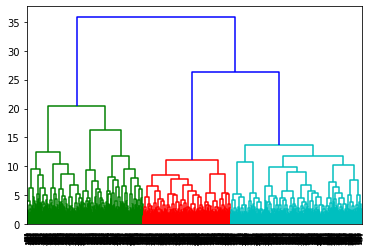

In [ ]:
df = audio_analysis_norm_genre
dend = shc.dendrogram(shc.linkage(df.drop(['Genero'], axis=1), method='ward'))

### Clustering sobre audio_feature

Evaluamos el número de cluster óptimo

In [39]:
df = audio_features_normalizadas

linkages = ["ward", "complete"]
affinities = ["euclidean", "l1", "l2", "manhattan", "cosine"]

for i in range(2,6,1):
    for linkage in linkages:
        for affinity in affinities:
            if linkage == 'ward' and affinity != "euclidean":
                continue
            print('Silhouette=', 
                  round(silhouette_score_hierarchical(df, label, i, linkage, affinity), 3), 
                  'Clusters[',i,'], Linkage[',linkage,']',
                  'Affinity[',affinity,'] ')
            print('Clusters',  ajuste_clusters_hierarchical(df, label, i, linkage, affinity))
            print()


Silhouette= 0.239 Clusters[ 2 ], Linkage[ ward ] Affinity[ euclidean ] 
Clusters [0.1301574333146388, 0.455280151717858]

Silhouette= 0.264 Clusters[ 2 ], Linkage[ complete ] Affinity[ euclidean ] 
Clusters [0.18343206038331053, 0.36218665707919157]

Silhouette= 0.253 Clusters[ 2 ], Linkage[ complete ] Affinity[ l1 ] 
Clusters [0.22697803008182346, 0.3197776739133815]

Silhouette= 0.264 Clusters[ 2 ], Linkage[ complete ] Affinity[ l2 ] 
Clusters [0.18343206038331053, 0.36218665707919157]

Silhouette= 0.253 Clusters[ 2 ], Linkage[ complete ] Affinity[ manhattan ] 
Clusters [0.22697803008182346, 0.3197776739133815]

Silhouette= 0.278 Clusters[ 2 ], Linkage[ complete ] Affinity[ cosine ] 
Clusters [0.293486518112735, 0.25603877481281884]

Silhouette= 0.235 Clusters[ 3 ], Linkage[ ward ] Affinity[ euclidean ] 
Clusters [0.10422757794523813, 0.39186762578389706, 0.25427640265503715]

Silhouette= 0.217 Clusters[ 3 ], Linkage[ complete ] Affinity[ euclidean ] 
Clusters [0.16431855148073443, 0

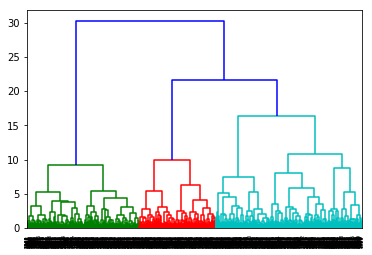

In [40]:
df = audio_features_normalizadas
dend = shc.dendrogram(shc.linkage(df.drop(['Genero'], axis=1), method='ward', metric='euclidean'))

In [41]:
hierarchical_audio_features = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(audio_features_normalizadas.drop(['Genero'],axis=1))

Devuelta lo mejor que da en este caso es para 2.

### Clustering sobre toda la base

Evaluación del número de clusters óptimo

In [42]:
df = pd.merge(audio_analysis_norm, audio_features_normalizadas, how='inner', left_index=True, right_index=True)

for i in range(2,10,1):
    print('Coeficiente de Silhouette promedio: ',
          round(silhouette_score_hierarchical(df, label, i), 3),
          ' para ', i,' clusters.')
    print('Ajuste de cada cluster particular: ', ajuste_clusters_hierarchical(df, label, i))
    print()

Coeficiente de Silhouette promedio:  0.13  para  2  clusters.
Ajuste de cada cluster particular:  [0.18651069874584705, 0.07507863179476965]

Coeficiente de Silhouette promedio:  0.061  para  3  clusters.
Ajuste de cada cluster particular:  [0.0356139227356764, 0.05703406517170419, 0.1257956219155551]

Coeficiente de Silhouette promedio:  0.016  para  4  clusters.
Ajuste de cada cluster particular:  [-0.056387976282749025, -0.003720853352722808, 0.12563851770099946, 0.13552880897830613]

Coeficiente de Silhouette promedio:  0.023  para  5  clusters.
Ajuste de cada cluster particular:  [-0.061829367049569345, -0.0037587260503389344, 0.12563851770099946, 0.13002693320456618, -0.01826018088114829]

Coeficiente de Silhouette promedio:  0.029  para  6  clusters.
Ajuste de cada cluster particular:  [-0.0037587260503389344, -0.02167118203712189, -0.011339336450798352, 0.1269648915146624, -0.04062903166225356, 0.12563851770099946]

Coeficiente de Silhouette promedio:  0.028  para  7  clusters.

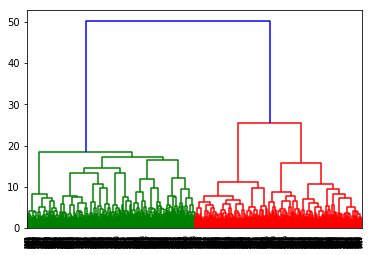

In [43]:
df = pd.merge(audio_analysis_norm, audio_features_normalizadas, how='inner', left_index=True, right_index=True)
dend = shc.dendrogram(shc.linkage(df.drop(['Genero'], axis=1), method='ward'))

Nuevamente lo mejor que da es para 2 clusters

b) Evaluar si los agrupamientos son similares para los distintos conjuntos de datos utilizando la matriz de confusión y los índices de Rand y van Dongen


In [44]:
hierarchical_audio_features = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
hierarchical_audio_features.fit(audio_features_normalizadas.drop(['Genero'],axis=1))

hierarchical_audio_analysis = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
hierarchical_audio_analysis.fit(audio_analysis_norm_genre.drop(['Genero'],axis=1))

tmp = pd.DataFrame({'Modelo_audio_features': hierarchical_audio_features.labels_, 'Modelo_audio_analysis': hierarchical_audio_analysis.labels_})
ct = pd.crosstab(tmp['Modelo_audio_features'], tmp['Modelo_audio_analysis'])
ct

Modelo_audio_analysis     0    1
Modelo_audio_features           
0                      1238  226
1                       201  539

In [45]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd
  
vanDongen(ct)

0.5674418604651162

c) Evaluar para los mejores casos si los clusters se condicen con el género


In [46]:
tmp = pd.DataFrame({'Labels': audio_features_normalizadas.Genero, 'Clusters': hierarchical_audio_features.labels_})
ct = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct

Clusters         0    1
Labels                 
ambient        204  256
classical       89  316
drum-and-bass  449    1
jazz           332   94
world-music    390   73

In [47]:
hierarchical_audio_analysis = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
hierarchical_audio_analysis.fit(audio_analysis_norm_genre.drop(['Genero'],axis=1))

tmp = pd.DataFrame({'Labels': audio_analysis_norm_genre.Genero, 'Clusters': hierarchical_audio_analysis.labels_})
ct = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct

Clusters         0    1
Labels                 
ambient        106  354
classical      135  270
drum-and-bass  445    5
jazz           383   43
world-music    370   93

d) Visualización de los clusters y etiquetas de género usando PCA


In [48]:
def drawClustersHierarchical(targetDf, n_clusters, dfName, linkage, affinity):
    # Copio primero el dataframe para no perder los datos
    df = targetDf.copy()

    m = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    m.fit(df.drop(['Genero'],axis=1))

    #Find which cluster each data-point belongs to
    #clusters = kmeans.predict(df.drop(['Genero'],axis=1))
    clusters = m.labels_

    #Add the cluster vector to our DataFrame, X
    df_clusters = df.copy()
    df_clusters["Cluster"] = clusters

    #PCA with two principal components
    pca_2d = PCA(n_components=2)
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(df_clusters.drop(["Cluster", "Genero"], axis=1)))
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    df_clusters["PC1_2d"] = np.array(PCs_2d["PC1_2d"])
    df_clusters["PC2_2d"] = np.array(PCs_2d["PC2_2d"])

    #Draw by cluster
    colors = ['rgba(0, 0, 255, 0.8)', 'rgba(0, 255, 0, 0.8)', 'rgba(0, 255, 255, 0.8)', 'rgba(255, 0, 0, 0.8)', 'rgba(255, 0, 255, 0.8)', 'rgba(255, 255, 0, 0.8)']
    traces = []
    for i in range(len(np.unique(clusters))):
        #-1 es noisy
        if i == -1:
            continue

        cluster = df_clusters[df_clusters["Cluster"] == i]
        trace = go.Scatter(
                          x = cluster["PC1_2d"],
                          y = cluster["PC2_2d"],
                          mode = "markers",
                          name = "Cluster " + str(i),
                          marker = dict(color = colors[i]),
                          text = None)
        traces.append(trace)
    
    layout = dict(title = "Visualización por Cluster usando PCA de " + dfName,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )
    fig = dict(data = traces, layout = layout)
    iplot(fig)

    # Draw by genre
    traces = []
    genres = ['jazz', 'classical', 'drum-and-bass', 'world-music', 'ambient']

    i = 0
    for genre in genres:
        genreCluster = df_clusters[df_clusters['Genero'] == genre]
        trace = go.Scatter(
                          x = genreCluster["PC1_2d"],
                          y = genreCluster["PC2_2d"],
                          mode = "markers",
                          name = genre,
                          marker = dict(color = colors[i]),
                          text = None)
        traces.append(trace)
        i += 1
  
    layout = dict(title = "Visualización por género usando PCA de " + dfName,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )
    fig = dict(data = traces, layout = layout)
    iplot(fig)

# Visualizamos para los 3 dataframes
drawClustersHierarchical(audio_features_normalizadas, 5, "Audio Features", "ward", "euclidean")


# Comparación k-means y jerárquico


In [49]:
tmp = pd.DataFrame({'Jerarquico': hierarchical_audio_features.labels_, 'KMeans': kmeans_audio_features.labels_})
ct = pd.crosstab(tmp['Jerarquico'], tmp['KMeans'])
ct

KMeans        0    1    2    3    4
Jerarquico                         
0            87  391   84  416  486
1           434    0  295    2    9